In [1]:
import os
os.chdir('..\\') # in ./tests folder - so changing to parent folder for imports

from consts import FOLDER2FLOW_RESULTS
import pandas as pd
import pprint
import matplotlib.pyplot as plt
from IPython.display import display

class df_extra:    
    def __init__(self, df):
        self.df = df
        self.num_rows = df.shape[0]
        self.data_dict = {}

    def add_data_to_df(self, col_name, data):
        self.data_dict[col_name] = [data]*self.num_rows
        self.df[col_name] = data

def create_united_df(date_folder, timelimit=0): # This is a df of all networks in folder
    res_dp = os.path.join(FOLDER2FLOW_RESULTS, date_folder)
    dfs_list = []
    for network in sorted(os.listdir(res_dp), reverse=True):
        df_fp = os.path.join(res_dp, network, "results.df")
        if network.endswith(".log") or not os.path.exists(df_fp):
            continue
        df = pd.read_pickle(df_fp)

        _df_extra = df_extra(df)
        _df_extra.add_data_to_df("network", network)
        _df_extra.add_data_to_df("mu", network.split("_")[1])

        dfs_list.append(df)
    df = pd.concat(dfs_list)
    df.reset_index(inplace=True)
    del df["index"]
    
    # replace names to shorter names for readabilty
    df["algo"].replace(f"NLP-100-TL-{timelimit}", "NLP100", inplace=True)
    df["algo"].replace(f"NLP-150-TL-{timelimit}", "NLP150", inplace=True)
    df["algo"].replace(f"NLP-200-TL-{timelimit}", "NLP200", inplace=True)
    
    return df

def prepare_data_for_plot(df):
    evals = ["avg_modularity", "std_modularity", "avg_jaccard", "std_jaccard"]
    mus = ["all", "0.4", "0.5", "0.6"]
    evals_dict = {}

    for mu in mus:
        evals_dict[mu] = {}
        for _eval in evals:
            evals_dict[mu][_eval] = {}

    for algo in df.algo.unique():
        for mu, evals in evals_dict.items():
    #         print(algo, mu)
            if mu == "all":
                algo_rows = df.loc[df["algo"]==algo]
            else:
                algo_rows = df.loc[df["algo"]==algo].loc[df["mu"]==mu]

            avg_modularity = algo_rows["modularity - algo"].mean()
            std_modularity = algo_rows["modularity - algo"].std()
            avg_jaccard = algo_rows["jaccard"].mean()
            std_jaccard = algo_rows["jaccard"].std()

            evals["avg_modularity"][algo] = avg_modularity
            evals["std_modularity"][algo] = std_modularity
            evals["avg_jaccard"][algo] = avg_jaccard
            evals["std_jaccard"][algo] = std_jaccard
    return evals_dict


def create_plots(data_for_plot):
    for mu, mu_evals in data_for_plot.items():
        for eval_name, eval_data in mu_evals.items():
            fig, ax = plt.subplots()
            ax.set_title(f'{eval_name}, mu={mu}')
            x = eval_data.values()
            y = eval_data.keys()
            ax.plot(y, x)
            ax.axhline(y=list(x)[1], color='r', linestyle='--')

            
# def run_visu(date_folder):
#     df = create_united_df(date_folder, timelimit=2400)
#     display(df)
#     data_for_plots = prepare_data_for_plot(df)
#     create_plots(data_for_plots)

def create_plot_all_mus(df, ev_col="modularity - algo", plot_name="modularity", num=0, path_to_save_figs=""):
    mus = ["0.4", "0.5", "0.6"]
        
    fig, (ax1, ax2) = plt.subplots(1, 2)
#     fig2, ax2 = plt.subplots()
    ax1.set_title(f'{plot_name}-mean')
    ax2.set_title(f'{plot_name}-std')

    for algo in df.algo.unique():
        x = [] # mus
        y_mean = [] # evals per mu
        y_std = []
    
        # avg_modularity
        for mu in mus:
#             print(f'{algo}, {mu}')
            algo_rows = df.loc[(df["mu"]==mu) & (df["algo"]==algo)]            
            algo_eval_rows = algo_rows[ev_col]
            y_mean.append(algo_eval_rows.mean())
            y_std.append(algo_eval_rows.std())
            x.append(mu)     
        ax1.plot(x, y_mean, label=f'{algo}')
        ax2.plot(x, y_std, label=f'{algo}')
    ax1.legend()
    ax2.legend()
    fig.tight_layout()
#     path_to_save_figs = os.path.join()
    fig.savefig(os.path.join(path_to_save_figs, f'{plot_name}.png'), format="png")

    
def create_graph(date_folder, ev_col="modularity - algo", plot_name="modularity", num=0):
    df = create_united_df(date_folder, timelimit=2400)
#     display(df)
    res_path = os.path.join(FOLDER2FLOW_RESULTS, date_folder, "figures")
    if not os.path.isdir(res_path):
        os.mkdir(res_path)
    create_plot_all_mus(df, ev_col, plot_name,  num, path_to_save_figs=res_path)
    return df

def get_avg_for_field(df, field):
    res_dict = {}
    for algo in df.algo.unique():
        for mu in df.mu.unique():
            if res_dict.get(algo) == None:
                res_dict[algo] = {}
            res_dict[algo][mu] = df.loc[(df["algo"]==algo) & (df["mu"]==mu)][field].mean()
        res_dict[algo]["all"] = sum(list(res_dict[algo].values()))/len(list(res_dict[algo].values()))
    return res_dict

In [2]:
# date_folder = "17-05-2022--13-36-06"
# date_folder = "17-05-2022--23-06-48-newman"
# run_visu(date_folder)

- check if there is an issue with manual modularity - for newman (bc of minus in modularity that we saw...)
- look at results: average of runtime, num_coms_divided over lp_criticals... decide if should run again with diff lp_criticals? 
- need to have same num of results per mu (lets say 5 results per mu)

# Newman: 1,000 nodes

,algo,modularity - real,modularity - algo,jaccard,graph_conductance,graph_sensitivity,graph_accuracy,num communities - real,num communities - algo,num_coms_divided,num_coms_skipped,number_of_mega_nodes,time-sec,network,mu
0,Louvain,0.363148,0.363821,0.504760,0.419840,0.978,0.813699,30,19,NaN,NaN,None,0.174008,1000_0.6_9,0.6
1,Newman,0.363148,0.320815,0.151359,0.449694,0.816,0.487295,30,8,NaN,NaN,None,0.632842,1000_0.6_9,0.6
2,NLP100,0.363148,0.321051,0.154032,0.440523,0.816,0.505379,30,9,1.0,5.0,None,22.588197,1000_0.6_9,0.6
3,NLP150,0.363148,0.337106,0.323700,0.392356,0.842,0.703032,30,19,7.0,1.0,None,480.422090,1000_0.6_9,0.6
4,NLP200,0.363148,0.318643,0.144852,0.453567,0.840,0.489285,30,8,1.0,1.0,None,2533.229047,1000_0.6_9,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,Louvain,0.565407,0.565846,0.939918,0.603204,1.000,0.978775,32,30,NaN,NaN,None,1.057482,1000_0.4_4,0.4
126,Newman,0.565407,0.565846,0.939918,0.603204,1.000,0.978775,32,30,NaN,NaN,None,6.744705,1000_0.4_4,0.4
127,NLP100,0.565407,0.565360,0.965798,0.601962,0.999,0.988444,32,31,12.0,0.0,None,810.287086,1000_0.4_4,0.4
128,NLP150,0.565407,0.565846,0.939918,0.603204,1.000,0.978775,32,30,10.0,0.0,None,1468.989558,1000_0.4_4,0.4


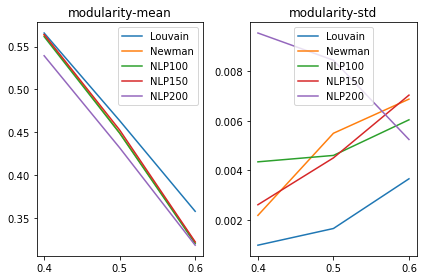

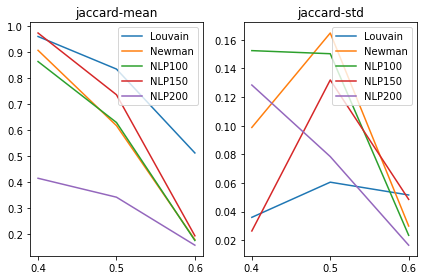

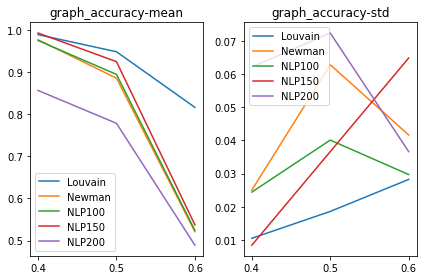

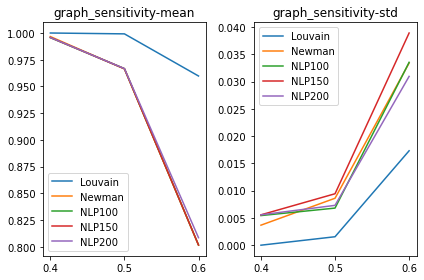

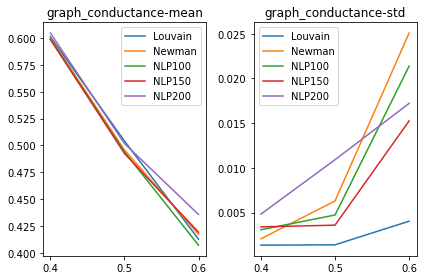

In [3]:
date_10000_nodes_folder = "17-05-2022--23-06-48-newman" 
df = create_graph(date_10000_nodes_folder)
df = create_graph(date_10000_nodes_folder, ev_col="jaccard", plot_name="jaccard")
df = create_graph(date_10000_nodes_folder, ev_col="graph_accuracy", plot_name="graph_accuracy")
df = create_graph(date_10000_nodes_folder, ev_col="graph_sensitivity", plot_name="graph_sensitivity")
df = create_graph(date_10000_nodes_folder, ev_col="graph_conductance", plot_name="graph_conductance")
display(df)

In [4]:
res_dict = get_avg_for_field(df, field="time-sec")
pprint.pprint(res_dict)

{'Louvain': {'0.4': 1.1365247166686459,
             '0.5': 0.7045533000004071,
             '0.6': 1.163112400000021,
             'all': 1.001396805556358},
 'NLP100': {'0.4': 819.3732405833313,
            '0.5': 287.0028800500011,
            '0.6': 300.245882510001,
            'all': 468.8740010477779},
 'NLP150': {'0.4': 1619.0150578333341,
            '0.5': 901.714198079997,
            '0.6': 2115.0158218200004,
            'all': 1545.248359244444},
 'NLP200': {'0.4': 3371.9935979999987,
            '0.5': 1930.99114203,
            '0.6': 3059.5524958700003,
            'all': 2787.5124119666666},
 'Newman': {'0.4': 6.326364199999564,
            '0.5': 2.9856555200014556,
            '0.6': 3.793826470000174,
            'all': 4.368615396667065}}


In [5]:
res_dict = get_avg_for_field(df, field="num_coms_divided")
pprint.pprint(res_dict)

{'Louvain': {'0.4': nan, '0.5': nan, '0.6': nan, 'all': nan},
 'NLP100': {'0.4': 11.666666666666666,
            '0.5': 9.3,
            '0.6': 1.4,
            'all': 7.455555555555556},
 'NLP150': {'0.4': 9.833333333333334,
            '0.5': 8.8,
            '0.6': 2.0,
            'all': 6.877777777777777},
 'NLP200': {'0.4': 5.333333333333333,
            '0.5': 5.2,
            '0.6': 1.1,
            'all': 3.8777777777777778},
 'Newman': {'0.4': nan, '0.5': nan, '0.6': nan, 'all': nan}}


# Louvain - 10,000 nodes

,algo,modularity - real,modularity - algo,jaccard,graph_conductance,graph_sensitivity,graph_accuracy,num communities - real,num communities - algo,num_coms_divided,num_coms_skipped,number_of_mega_nodes,iterations,time-sec,network,mu
0,Louvain,0.396218,0.406160,0.182675,0.423353,0.9984,0.502688,303,58,None,None,NaN,NaN,2.767486,10000_0.6_9,0.6
1,LLP-70,0.396218,0.405728,0.194571,0.421511,0.9985,0.520378,303,62,None,None,62.0,3.0,4.796015,10000_0.6_9,0.6
2,LLP-150,0.396218,0.405771,0.183203,0.422493,0.9976,0.509681,303,59,None,None,106.0,2.0,311.397457,10000_0.6_9,0.6
3,Louvain,0.396054,0.405722,0.187187,0.422092,0.9976,0.515810,307,60,None,None,NaN,NaN,2.201684,10000_0.6_8,0.6
4,LLP-70,0.396054,0.405819,0.197031,0.421922,0.9977,0.524372,307,62,None,None,62.0,3.0,4.736283,10000_0.6_8,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,LLP-70,0.596227,0.601815,0.304883,0.612167,1.0000,0.628888,304,95,None,None,95.0,3.0,8.646558,10000_0.4_1,0.4
86,LLP-150,0.596227,0.601663,0.308141,0.612135,1.0000,0.633167,304,96,None,None,107.0,2.0,18.646255,10000_0.4_1,0.4
87,Louvain,0.596272,0.601772,0.299393,0.612187,1.0000,0.628172,304,94,None,None,NaN,NaN,1.929988,10000_0.4_0,0.4
88,LLP-70,0.596272,0.601871,0.294277,0.612421,1.0000,0.619758,304,93,None,None,93.0,3.0,8.107018,10000_0.4_0,0.4


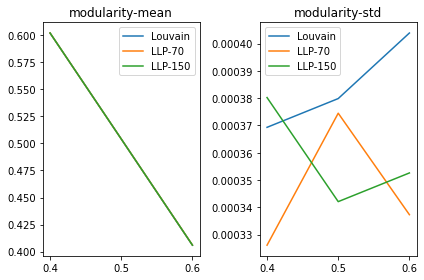

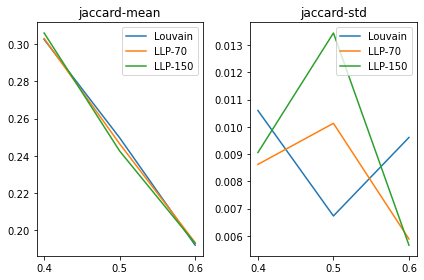

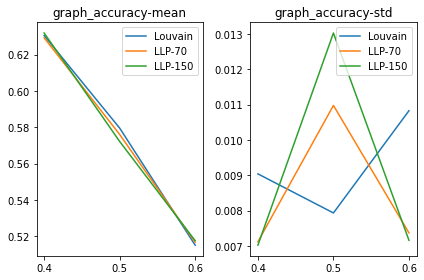

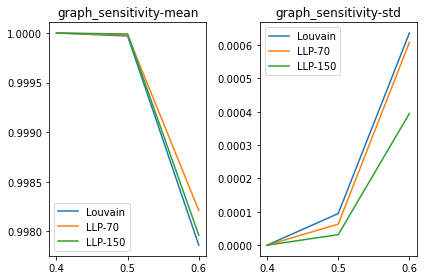

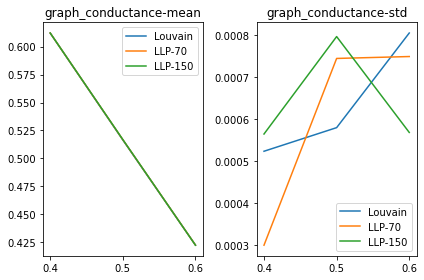

In [6]:
date_10000_nodes_folder = "26-05-2022--14-00-54-louvain-10000" 
df = create_graph(date_10000_nodes_folder)
df = create_graph(date_10000_nodes_folder, ev_col="jaccard", plot_name="jaccard")
df = create_graph(date_10000_nodes_folder, ev_col="graph_accuracy", plot_name="graph_accuracy")
df = create_graph(date_10000_nodes_folder, ev_col="graph_sensitivity", plot_name="graph_sensitivity")
df = create_graph(date_10000_nodes_folder, ev_col="graph_conductance", plot_name="graph_conductance")
display(df)

# Louvain - 1,000 nodes

,algo,modularity - real,modularity - algo,jaccard,graph_conductance,graph_sensitivity,graph_accuracy,num communities - real,num communities - algo,num_coms_divided,num_coms_skipped,number_of_mega_nodes,iterations,time-sec,network,mu
0,Louvain,0.363148,0.359769,0.514590,0.414455,0.974,0.827479,30,20,None,None,NaN,NaN,0.170578,1000_0.6_9,0.6
1,LLP-100,0.363148,0.360630,0.476668,0.419483,0.972,0.800342,30,19,None,None,31.0,1.0,0.620861,1000_0.6_9,0.6
2,LLP-100,0.363148,0.366264,0.590537,0.417554,0.981,0.844504,30,20,None,None,35.0,1.0,0.735362,1000_0.6_9,0.6
3,LLP-100,0.363148,0.360157,0.553905,0.410523,0.956,0.839388,30,21,None,None,32.0,1.0,0.699961,1000_0.6_9,0.6
4,LLP-100,0.363148,0.361996,0.519911,0.418192,0.973,0.812814,30,19,None,None,35.0,1.0,0.660898,1000_0.6_9,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,LLP-100,0.564733,0.565410,0.886834,0.603145,1.000,0.965919,31,28,None,None,33.0,1.0,0.573977,1000_0.4_0,0.4
326,LLP-100,0.564733,0.565410,0.886834,0.603145,1.000,0.965919,31,28,None,None,31.0,1.0,0.407282,1000_0.4_0,0.4
327,LLP-100,0.564733,0.565410,0.886834,0.603145,1.000,0.965919,31,28,None,None,32.0,1.0,0.498012,1000_0.4_0,0.4
328,LLP-100,0.564733,0.565410,0.886834,0.603145,1.000,0.965919,31,28,None,None,32.0,1.0,0.505108,1000_0.4_0,0.4


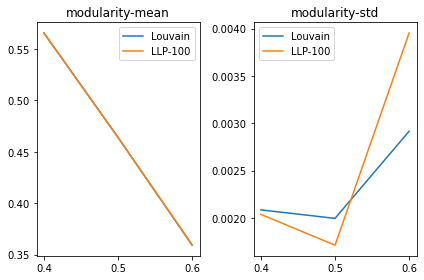

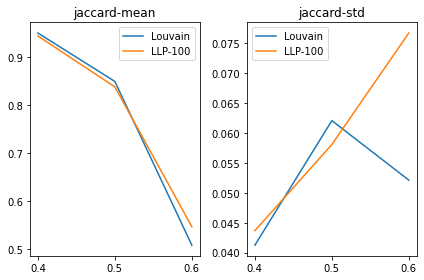

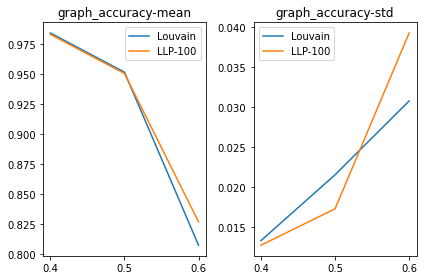

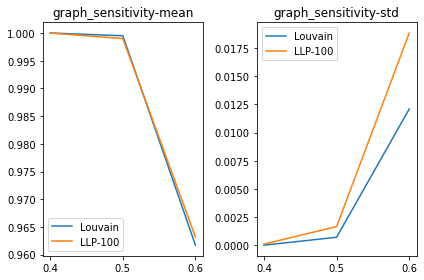

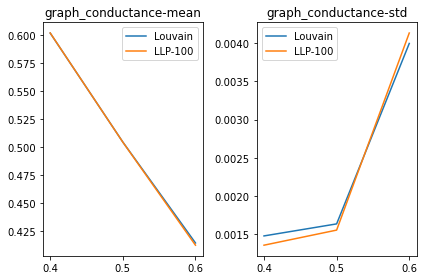

In [7]:
date_10000_nodes_folder = "26-05-2022--15-13-20-louvain-1000"
df = create_graph(date_10000_nodes_folder)
df = create_graph(date_10000_nodes_folder, ev_col="jaccard", plot_name="jaccard")
df = create_graph(date_10000_nodes_folder, ev_col="graph_accuracy", plot_name="graph_accuracy")
df = create_graph(date_10000_nodes_folder, ev_col="graph_sensitivity", plot_name="graph_sensitivity")
df = create_graph(date_10000_nodes_folder, ev_col="graph_conductance", plot_name="graph_conductance")
display(df)